In [1]:
import os
from pathlib import Path
USER_HOME = str(Path.home())
IWN_DATA_PATH = os.path.join(*[USER_HOME, 'iwn_data'])

IWN_DATA_PATH, os.path.exists(IWN_DATA_PATH)

('/Users/xiaofeiwu/iwn_data', True)

In [2]:
import pyiwn
iwn = pyiwn.IndoWordNet()

2020-03-14:19:59:45,829 INFO     [iwn.py:43] Loading hindi language synsets...


In [3]:
all_syns=iwn.all_synsets()
len(all_syns)

40360

In [4]:
all_syns[:3]

[Synset('अजन्मा.adjective.1'),
 Synset('स्वयंभू.adjective.30168'),
 Synset('अशुभ.adjective.2')]

In [5]:
from pyiwn.iwn import Synset
Synset.__name__

'Synset'

In [6]:
type(all_syns[0]).__name__

'Synset'

In [7]:
type(all_syns[0])==Synset

True

In [8]:
from pyiwn import PosTag 
all_nouns=iwn.all_synsets(pos=PosTag.NOUN)
print(len(all_nouns), all_nouns[:3],
      [w.synset_id() for w in all_nouns[:3]]
     )

29846 [Synset('पवित्र स्थान.noun.4'), Synset('शिवालय.noun.5'), Synset('अपवित्र स्थान.noun.6')] [4, 5, 6]


In [9]:
from sagas.nlu.transliterations import translits
from sagas.nlu.google_translator import translate, with_words, WordsObserver
tr=lambda w:translits.translit(w, 'hi')
def trans(w):
    r,t=translate(w, source='hi', target='en', options={'get_pronounce'}, tracker=with_words())
    df=t.observer(WordsObserver).word_trans_df
    if df is not None:
        candidates=[w for w in df['word']][:3]
    else:
        candidates=[]
    return {'word': r.lower(),
            'candidates':candidates}
def word_map(id):
    return {tr(w.head_word()):{'index':w.synset_id(), 'head':w.head_word(), 'trans':trans(w.head_word())} for w in all_nouns if w.synset_id()==id}
def word_list(id):
    return [{tr(w.head_word()):(w.head_word(), trans(w.head_word()))} for w in all_nouns if w.synset_id()==id]
word_map(14396)
# word_list(14396)

{'phutabala': {'index': 14396,
  'head': 'फुटबाल',
  'trans': {'word': 'football', 'candidates': ['football']}}}

In [10]:
from sagas.nlu.google_translator import translate, with_words, WordsObserver
r,t=translate('गतिविधि', source='hi', target='en', options={'get_pronounce'}, tracker=with_words())
print(r)
t.observer(WordsObserver).word_trans_df

Activity


,word,translations
0,behaviour,"[व्यवहार, बर्ताव, गतिविधि, चाल-चलन]"
1,development,"[वृद्धि, गतिविधि, घटनाक्रम, विस्तार]"


In [11]:
[w for w in t.observer(WordsObserver).word_trans_df['word']][:3]

['behaviour', 'development']

In [12]:
word_map(672)

{'khelakuda': {'index': 672,
  'head': 'खेलकूद',
  'trans': {'word': 'sports',
   'candidates': ['athletics', 'pastime', 'games & sport']}}}

In [13]:
word_list(673)

[{'gatividhi': ('गतिविधि',
   {'word': 'activity', 'candidates': ['behaviour', 'development']})}]

In [14]:
def fn(*arg):
    print(list(arg))
fn()

[]


In [15]:
data_path='/pi/ai/nltk/hindi/iwn_data/synset_relations/hypernymy.noun'
def load_hypernymy(file_path):
    d = {}
    for line in open(file_path):
        line_parts = line.split('\t')
        synset_id, synset_ids = line_parts
        synset_id = int(synset_id)
        synset_ids = list(map(int, synset_ids.split(',')))
        # synset_ids = list(filter(lambda x: True if x in self._synset_df.index else False, synset_ids))
        if synset_id in d:
            d[synset_id].extend(synset_ids)
        else:
            if synset_ids:
                d[synset_id] = synset_ids
    return d
hypers=load_hypernymy(data_path)

In [16]:
hypers[14396], hypers[672], hypers[183] # , hypers[12149]

([672], [673], [12149])

In [17]:
def get_all_hypers(syn_ids, results):
    for syn_id in syn_ids:
        if syn_id in hypers:
            results.append(syn_id)
            get_all_hypers(hypers[syn_id], results)
# [syn_id for syn_id in get_all_hypers([14396])]
results=[]
get_all_hypers([14396], results)
results

[14396, 672, 673, 183]

In [18]:
for sid in results:
    print(word_map(sid))

{'phutabala': {'index': 14396, 'head': 'फुटबाल', 'trans': {'word': 'football', 'candidates': ['football']}}}
{'khelakuda': {'index': 672, 'head': 'खेलकूद', 'trans': {'word': 'sports', 'candidates': ['athletics', 'pastime', 'games & sport']}}}
{'gatividhi': {'index': 673, 'head': 'गतिविधि', 'trans': {'word': 'activity', 'candidates': ['behaviour', 'development']}}}
{'kama': {'index': 183, 'head': 'काम', 'trans': {'word': 'work', 'candidates': ['job', 'task', 'deed']}}}


In [19]:
def get_word_hypers(word):
    results=[]
    ids=[syn.synset_id() for syn in iwn.synsets(word)]
    get_all_hypers(ids, results)
    return [word_map(sid) for sid in results]
get_word_hypers('सेब')

[{'seba': {'index': 8357,
   'head': 'सेब',
   'trans': {'word': 'apple', 'candidates': ['apple']}}},
 {'pera': {'index': 2349,
   'head': 'पेड़',
   'trans': {'word': 'tree', 'candidates': ['tree']}}},
 {'vanaspati': {'index': 1249,
   'head': 'वनस्पति',
   'trans': {'word': 'plant', 'candidates': ['vegetable']}}},
 {'jiva': {'index': 1998,
   'head': 'जीव',
   'trans': {'word': 'creatures',
    'candidates': ['organism', 'creature', 'subaerial']}}},
 {'vastu': {'index': 923,
   'head': 'वस्तु',
   'trans': {'word': 'thing', 'candidates': ['object', 'commodity', 'item']}}},
 {'seba': {'index': 8358,
   'head': 'सेब',
   'trans': {'word': 'apple', 'candidates': ['apple']}}},
 {'khadya phala': {'index': 4650,
   'head': 'खाद्य फल',
   'trans': {'word': 'edible fruits', 'candidates': []}}}]

In [39]:
def get_hypers_by_id(ids):
    results=[]
    get_all_hypers(ids if isinstance(ids, list) else [ids], results)
    return [word_map(sid) for sid in results]
get_hypers_by_id(8358)

[{'seba': {'index': 8358,
   'head': 'सेब',
   'trans': {'word': 'apple', 'candidates': ['apple']}}},
 {'khadya phala': {'index': 4650,
   'head': 'खाद्य फल',
   'trans': {'word': 'edible fruits', 'candidates': []}}}]

In [40]:
iwn.synsets('सेब')

[Synset('सेब.noun.8357'), Synset('सेब.noun.8358')]

In [41]:
iwn.synsets('परिवार')

[Synset('परिवार.noun.4388'),
 Synset('परिवार.noun.28473'),
 Synset('परिवार.noun.35693'),
 Synset('परिवार.noun.35694'),
 Synset('परिवार.noun.35695')]

In [42]:
get_word_hypers('परिवार')

[{'parivara': {'index': 4388,
   'head': 'परिवार',
   'trans': {'word': 'family', 'candidates': ['family', 'house', 'kin']}}},
 {'loga': {'index': 189,
   'head': 'लोग',
   'trans': {'word': 'people', 'candidates': ['people', 'folk', 'demos']}}},
 {'samudaya': {'index': 10729,
   'head': 'समुदाय',
   'trans': {'word': 'community',
    'candidates': ['community', 'summation', 'party']}}},
 {'vastu': {'index': 923,
   'head': 'वस्तु',
   'trans': {'word': 'thing', 'candidates': ['object', 'commodity', 'item']}}},
 {'parivara': {'index': 28473,
   'head': 'परिवार',
   'trans': {'word': 'family', 'candidates': ['family', 'house', 'kin']}}},
 {'samudaya': {'index': 10729,
   'head': 'समुदाय',
   'trans': {'word': 'community',
    'candidates': ['community', 'summation', 'party']}}},
 {'vastu': {'index': 923,
   'head': 'वस्तु',
   'trans': {'word': 'thing', 'candidates': ['object', 'commodity', 'item']}}},
 {'parivara': {'index': 35693,
   'head': 'परिवार',
   'trans': {'word': 'family', 'c

In [21]:
syns=iwn.synsets('तेल')
for syn in syns:
    rels=iwn.synset_relation(syn, pyiwn.SynsetRelations.HYPERNYMY)
    if rels:
        print('hyper', syn, rels)
    rels=iwn.synset_relation(syn, pyiwn.SynsetRelations.HYPONYMY)
    if rels:
        print('hypo', syn, rels)

hypo Synset('तेल.noun.480') [Synset('तारपीन.noun.5978'), Synset('खनिज तेल.noun.6029'), Synset('खाद्य तेल.noun.6030'), Synset('वनस्पतीय तेल.noun.6032'), Synset('फुलेल.noun.9546'), Synset('निशातैल.noun.16556'), Synset('लाक्षातैल.noun.17506'), Synset('दीपिकातैल.noun.17589'), Synset('दीक.noun.17789'), Synset('ग्रीस.noun.18990'), Synset('औंगन.noun.18991'), Synset('मसाला.noun.29560'), Synset('ताड़पीन तेल.noun.32112'), Synset('तैलिन.noun.32324'), Synset('चंदनादि-तैल.noun.32325'), Synset('कोकम का तेल.noun.35174'), Synset('नारियल तेल.noun.37441')]
hypo Synset('खनिज तेल.noun.6029') [Synset('डीजल.noun.20150'), Synset('पेट्रोल.noun.20151'), Synset('नैफ्था.noun.23783')]


In [22]:
iwn.synset_relation(iwn.synsets('सेब')[0], pyiwn.SynsetRelations.HYPERNYMY)
# HYPONYMY
# iwn.synset_relation(iwn.synsets('सेब')[0], pyiwn.SynsetRelations.HYPONYMY)

[]

In [23]:
aam_synsets=iwn.synsets('फ़ुटबाल')
aam_synsets

[Synset('फुटबाल.noun.14395'), Synset('फुटबाल.noun.14396')]

In [24]:
aam_synsets[0].examples()

['फुटबाल में हवा कम है इसलिए मारने पर अधिक दूर नहीं जा रहा है ।']

In [25]:
aam_synsets[0].gloss()

'मैदान में खेलने की एक बड़ी गेंद जिसे पैर से मारते हैं'

In [26]:
from sagas.nlu.transliterations import translits
translits.translit('फ़ुटबाल', 'hi')

'futabala'

In [27]:
translits.translit('फुटबाल.noun.14395', 'hi')

'phutabala.noun.14395'

In [28]:
from sagas.nlu.transliterations import translits
# aam = aam_synsets[0]
def print_syns(aam_synsets):
    for aam in aam_synsets:
        head=translits.translit(aam.head_word(), 'hi')
        print(f"{head}.{aam.pos()}.{aam.synset_id()}" ,
              [translits.translit(lemma,'hi') for lemma in aam.lemma_names()])
aam_synsets=iwn.synsets('फ़ुटबाल')
print_syns(aam_synsets)

phutabala.noun.14395 ['phutabala', 'futabala', 'phutabola', 'futabola']
phutabala.noun.14396 ['phutabala', 'futabala', 'phutabola', 'futabola']


In [29]:
from sagas.nlu.google_translator import translate
r, _ = translate('फुटबाल', source='hi', target='en', options={'get_pronounce'})
r

'Football'

In [30]:
# syns=iwn.synsets('तेल')
syns=iwn.synsets('फुटबाल')
for syn in syns:
    rels=iwn.synset_relation(syn, pyiwn.SynsetRelations.HYPERNYMY)
    if rels:
        print('++ hyper', syn, rels)
    rels=iwn.synset_relation(syn, pyiwn.SynsetRelations.HYPONYMY)
    if rels:
        print('** hypo', syn)
        print_syns(rels)

** hypo Synset('फुटबाल.noun.14396')
ragbi.noun.25718 ['ragbi', 'ragabi', 'ragabi phutabala', 'ragbi phutabala']


In [31]:
aam = aam_synsets[0]
hyponyms = iwn.synset_relation(aam, pyiwn.SynsetRelations.HYPONYMY)
len(hyponyms)

0

In [32]:
print_syns(hyponyms)

In [33]:
iwn.synset_relation(aam, pyiwn.SynsetRelations.HYPERNYMY)

[]

In [34]:
from anytree import Node, RenderTree
udo = Node("Udo")
marc = Node("Marc", parent=udo)
lian = Node("Lian", parent=marc)
dan = Node("Dan", parent=udo)
jet = Node("Jet", parent=dan)
jan = Node("Jan", parent=dan)
joe = Node("Joe", parent=dan)

In [35]:
print(udo)

Node('/Udo')


In [36]:
for pre, fill, node in RenderTree(udo):
    print("%s%s" % (pre, node.name))

Udo
├── Marc
│   └── Lian
└── Dan
    ├── Jet
    ├── Jan
    └── Joe


In [37]:
print(RenderTree(udo))

Node('/Udo')
├── Node('/Udo/Marc')
│   └── Node('/Udo/Marc/Lian')
└── Node('/Udo/Dan')
    ├── Node('/Udo/Dan/Jet')
    ├── Node('/Udo/Dan/Jan')
    └── Node('/Udo/Dan/Joe')


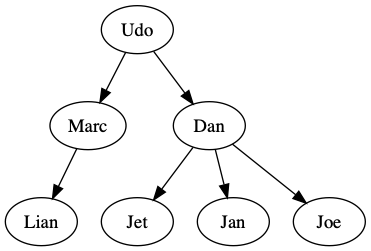

In [38]:
from anytree.exporter import DotExporter
from IPython.display import Image
# graphviz needs to be installed for the next line!
DotExporter(udo).to_picture("udo.png")
Image(filename='udo.png') 